In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mido import MidiFile, tick2second
from pretty_midi import PrettyMIDI
import pickle
import os
from os import path
import time

### Generating bootleg score

In [3]:
def showImage(X, sz = (6,6)):
    plt.figure(figsize = sz)
    plt.imshow(X, cmap = 'gray', origin = 'lower')

In [4]:
def getNoteEvents(midifile, quant = 10):
    ### Given a midi file, return a list of (t_tick, t_sec, notes) tuples for simultaneous note events
    
    # get note onset info
    mid = MidiFile(midifile)
    noteEvents = []
    checkForDuplicates = {}
    for i, track in enumerate(mid.tracks):
        t = 0 
        for msg in track:
            t += msg.time # ticks since last event
            if msg.type == 'note_on' and msg.velocity > 0:
                key = '{},{}'.format(t,msg.note)
                if key not in checkForDuplicates:
                    noteEvents.append((t, msg.note))
                    checkForDuplicates[key] = 0
    noteEvents = sorted(noteEvents) # merge note events from all tracks, sort by time
    pm = PrettyMIDI(midifile)
    noteOnsets = [(t_ticks, pm.tick_to_time(t_ticks), note) for (t_ticks, note) in noteEvents]
    
    # collapse simultaneous notes
    d = {}
    ticks_quant = [n[0]//quant for n in noteOnsets] # quantized time units (ticks)
    for n, t_quant in zip(noteOnsets, ticks_quant):
        if t_quant not in d:
            d[t_quant] = {}
            d[t_quant]['ticks'] = []
            d[t_quant]['secs'] = []
            d[t_quant]['notes'] = []
        d[t_quant]['ticks'].append(n[0])
        d[t_quant]['secs'].append(n[1])
        d[t_quant]['notes'].append(n[2])
        
    result = [(d[key]['ticks'][0], d[key]['secs'][0], d[key]['notes']) for key in sorted(d.keys())]
    
    return result, d # return d for debugging

In [5]:
def generateBootlegScore(noteEvents, repeatNotes = 1, filler = 0):
    rh_dim = 34 # E3 to C8 (inclusive)
    lh_dim = 28 # A1 to G4 (inclusive)
    rh = [] # list of arrays of size rh_dim
    lh = [] # list of arrays of size lh_dim
    numNotes = [] # number of simultaneous notes
    times = [] # list of (tsec, ttick) tuples indicating the time in ticks and seconds
    mapR, mapL = getNoteheadPlacementMapping() # maps midi numbers to locations on right and left hand staves
    for i, (ttick, tsec, notes) in enumerate(noteEvents):
        
        # insert empty filler columns between note events
        if i > 0:
            for j in range(filler):
                rh.append(np.zeros((rh_dim,1)))
                lh.append(np.zeros((lh_dim,1)))
                numNotes.append(0)
            # get corresponding times using linear interpolation
            interp_ticks = np.interp(np.arange(1, filler+1), [0, filler+1], [noteEvents[i-1][0], ttick])
            interp_secs = np.interp(np.arange(1, filler+1), [0, filler+1], [noteEvents[i-1][1], tsec])
            for tup in zip(interp_secs, interp_ticks):
                times.append((tup[0], tup[1]))

        # insert note events columns
        rhvec = np.zeros((rh_dim, 1))
        lhvec = np.zeros((lh_dim, 1))
        for midinum in notes:
            rhvec += getNoteheadPlacement(midinum, mapR, rh_dim)
            lhvec += getNoteheadPlacement(midinum, mapL, lh_dim)
        for j in range(repeatNotes):
            rh.append(rhvec)
            lh.append(lhvec)
            numNotes.append(len(notes))
            times.append((tsec, ttick))
    rh = np.clip(np.squeeze(np.array(rh)).T, 0, 1) # clip in case e.g. E and F played simultaneously
    lh = np.clip(np.squeeze(np.array(lh)).T, 0, 1) 
    both = np.vstack((lh, rh))
    staffLinesRH = [7,9,11,13,15]
    staffLinesLH = [13,15,17,19,21]
    staffLinesBoth = [13,15,17,19,21,35,37,39,41,43]
    return both, times, numNotes, staffLinesBoth, (rh, staffLinesRH), (lh, staffLinesLH)

In [6]:
def getNoteheadPlacementMapping():
    r = getNoteheadPlacementMappingRH()
    l = getNoteheadPlacementMappingLH()
    r, l = addOctaveChanges(r, l) # uncomment to include octave markings
    r, l = addClefChanges(r, l) # uncomment to include different clefs
    return r, l

In [7]:
def getNoteheadPlacementMappingLH():
    d = {}
    # e.g. d[23] = [1,2] indicates that B0 could appear as a B or a C-flat, which means
    # that the notehead could be located at positions 1 or 2
    d[21] = [0] # A0 (position 0)
    d[22] = [0,1]
    d[23] = [1,2] # B0
    d[24] = [1,2] # C1
    d[25] = [2,3]
    d[26] = [3] # D1
    d[27] = [3,4]
    d[28] = [4,5] # E1
    d[29] = [4,5] # F1
    d[30] = [5,6]
    d[31] = [6] # G1
    d[32] = [6,7] 
    d[33] = [7] # A1
    d[34] = [7,8]
    d[35] = [8,9] # B1
    d[36] = [8,9] # C2
    d[37] = [9,10] 
    d[38] = [10] # D2
    d[39] = [10,11] 
    d[40] = [11,12] # E2
    d[41] = [11,12] # F2
    d[42] = [12,13] 
    d[43] = [13] # G2
    d[44] = [13,14] 
    d[45] = [14] # A2
    d[46] = [14,15] 
    d[47] = [15,16] # B2
    d[48] = [15,16] # C3
    d[49] = [16,17] 
    d[50] = [17] # D3
    d[51] = [17,18] 
    d[52] = [18,19] # E3
    d[53] = [18,19] # F3
    d[54] = [19,20] 
    d[55] = [20] # G3
    d[56] = [20,21] 
    d[57] = [21] # A3
    d[58] = [21,22] 
    d[59] = [22,23] # B3
    d[60] = [22,23] # C4
    d[61] = [23,24] 
    d[62] = [24] # D4
    d[63] = [24,25] 
    d[64] = [25,26] # E4
    d[65] = [25,26] # F4
    d[66] = [26,27] 
    d[67] = [27] # G4
    return d

In [8]:
def getNoteheadPlacementMappingRH():
    d = {}
    # e.g. d[52] = [0,1] indicates that E3 could appear as an E or an F-flat, which means
    # that the notehead could be located at positions 0 or 1
    d[52] = [0,1] # E3 (position 0)
    d[53] = [0,1] # F3
    d[54] = [1,2]
    d[55] = [2] # G3
    d[56] = [2,3]
    d[57] = [3] # A3
    d[58] = [3,4]
    d[59] = [4,5] # B3
    d[60] = [4,5] # C4
    d[61] = [5,6]
    d[62] = [6] # D4
    d[63] = [6,7]
    d[64] = [7,8] # E4
    d[65] = [7,8] # F4
    d[66] = [8,9]
    d[67] = [9] # G4
    d[68] = [9,10]
    d[69] = [10] # A4
    d[70] = [10,11]
    d[71] = [11,12] # B4
    d[72] = [11,12] # C5
    d[73] = [12,13]
    d[74] = [13] # D5
    d[75] = [13,14]
    d[76] = [14,15] # E5
    d[77] = [14,15] # F5
    d[78] = [15,16]
    d[79] = [16] # G5
    d[80] = [16,17]
    d[81] = [17] # A5
    d[82] = [17,18] 
    d[83] = [18,19] # B5
    d[84] = [18,19] # C6
    d[85] = [19,20]
    d[86] = [20] # D6
    d[87] = [20,21]
    d[88] = [21,22] # E6
    d[89] = [21,22] # F6
    d[90] = [22,23]
    d[91] = [23] # G6
    d[92] = [23,24] 
    d[93] = [24] # A6
    d[94] = [24,25]
    d[95] = [25,26] # B6
    d[96] = [25,26] # C7
    d[97] = [26,27]
    d[98] = [27] # D7
    d[99] = [27,28] 
    d[100] = [28,29] # E7
    d[101] = [28,29] # F7
    d[102] = [29,30]
    d[103] = [30] # G7
    d[104] = [30,31]    
    d[105] = [31] # A7
    d[106] = [31,32]
    d[107] = [32,33] # B7
    d[108] = [32,33] # C8
    return d

In [9]:
def addOctaveChanges(r, l):
    
    # add octaves in treble clef for G5 and above
    for midinum in r:
        if midinum >= 79:
            toAdd = []
            for staffpos in r[midinum]:
                toAdd.append(staffpos - 7) # 7 staff positions = 1 octave
            r[midinum].extend(toAdd)
    
    # add octaves in bass clef for F2 and below
    for midinum in l:
        if midinum <= 41:
            toAdd = []
            for staffpos in l[midinum]:
                toAdd.append(staffpos + 7)
            l[midinum].extend(toAdd)
    
    return r, l

In [10]:
def addClefChanges(r, l):
    
    # clef change in rh
    for midinum in range(36, 65):  # C2 to E4
        if midinum not in r:
            r[midinum] = []
        for staffpos in l[midinum]:
            r[midinum].append(staffpos - 6) # shift between L and R staves (e.g. middle staff line is pos 11 in rh, pos 17 in lh)
            
    # clef change in lh
    for midinum in range(57, 85): # A3 to C6
        if midinum not in l:
            l[midinum] = []
        for staffpos in r[midinum]:
            l[midinum].append(staffpos + 6)
            
    return r, l

In [11]:
def getNoteheadPlacement(midinum, midi2loc, dim):
    r = np.zeros((dim, 1))
    if midinum in midi2loc:
        for idx in midi2loc[midinum]:
            r[idx,0] = 1
    return r

In [12]:
def visualizeBootlegScore(bs, lines):
    showImage(1 - bs, (10,10))
    for l in range(1, bs.shape[0], 2):
        plt.axhline(l, c = 'b')
    for l in lines:
        plt.axhline(l, c = 'r')

In [13]:
midifile_1 = '/home/mshan/ttemp/data/midi/p111.mid'

In [14]:
midifile_2 = '/home/mshan/ttemp/data/gen_midi/0/p111.midi'

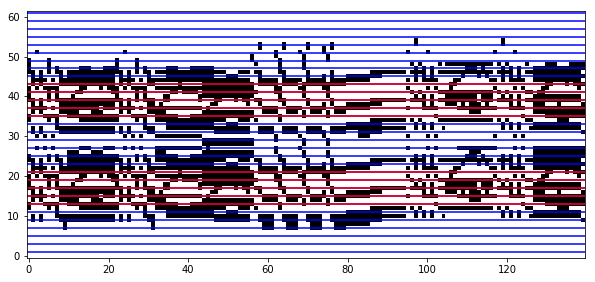

In [16]:
note_events, _ = getNoteEvents(midifile_1)
bscore, times, num_notes, stafflines, _, _ = generateBootlegScore(note_events, 1, 0)
visualizeBootlegScore(bscore[:,0:140], stafflines)

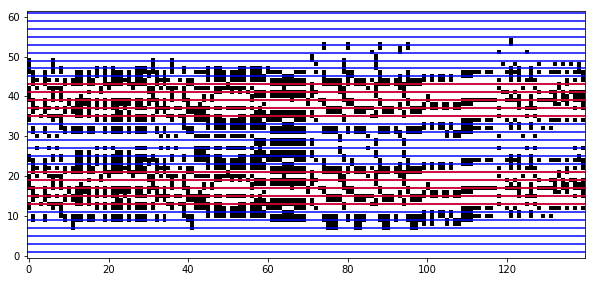

In [16]:
note_events, _ = getNoteEvents(midifile_2)
bscore, times, num_notes, stafflines, _, _ = generateBootlegScore(note_events, 1, 0)
visualizeBootlegScore(bscore[:,0:140], stafflines)

### Process MIDI files

In [17]:
def processMidiFile(midifile, outfile):
    
    ### system parameters ###
    timeQuantFactor = 10
    bootlegRepeatNotes = 1
    bootlegFiller = 0
    #########################
    
    print("Extracting bootleg score of {}".format(midifile))
    note_events, _ = getNoteEvents(midifile, timeQuantFactor)
    bscore, times, num_notes, stafflines, _, _ = generateBootlegScore(note_events, bootlegRepeatNotes, bootlegFiller)
    
    # save to file
    d = {'bscore': bscore, 'times': times, 'num_notes': num_notes, 'stafflines': stafflines, 'note_events': note_events}
    with open(outfile, 'wb') as f:
        pickle.dump(d, f)

In [19]:
def processAudioFile(piece, i, data='data'):
    '''
    input:
        filename: in the form of 'p1.wav'.
    
    Will convert the wav file to midi file and calculate the bootleg score.
    '''
    filename = 'p' + str(piece)
    print("Converting " + filename + " to MIDI...")
    res_dir = "/home/mshan/ttemp/{}/bscore/{}/{}.pkl".format(data, i, filename)
    os.makedirs(path.dirname(res_dir), exist_ok=True)
    if not path.exists(res_dir):
        cmd = "onsets_frames_transcription_transcribe --model_dir=/home/mshan/spring2020/magenta/train /home/mshan/ttemp/{}/audio/{}/{}.wav".format(data, i, filename)
        os.system(cmd)
        processMidiFile("/home/mshan/ttemp/{}/audio/{}/{}.wav.midi".format(data, i, filename), res_dir)

### Run the experiment: convert all audio files to bootleg pkl.

In [18]:
import multiprocessing
from multiprocessing import Pool
from itertools import repeat

In [29]:
pool = Pool(12)
datas = ['data_repeat1', 'data_repeat2', 'data_repeat3', 'data_dsalfine']
pool.starmap(processAudioFile, zip(list(range(1, 201))*4, [1]*200+[2]*200+[3]*200+[4]*200, ['data_dsalfine'] * 800))
pool.close() 
pool.join()

Converting p1 to MIDI...
Converting p35 to MIDI...
Converting p18 to MIDI...
Converting p154 to MIDI...
Converting p103 to MIDI...
Converting p52 to MIDI...
Converting p69 to MIDI...
Converting p86 to MIDI...
Converting p137 to MIDI...
Converting p188 to MIDI...
Converting p171 to MIDI...
Converting p120 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/1/p154.wav.midi
Converting p155 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/1/p52.wav.midi
Converting p53 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/1/p35.wav.midi
Converting p36 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/1/p69.wav.midi
Converting p70 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/1/p137.wav.midi
Converting p138 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/1/p171.wav.midi
Converting p172 to MIDI...
Extracting bootleg score of /home/m

Converting p26 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/1/p193.wav.midi
Converting p194 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/1/p126.wav.midi
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/1/p141.wav.midi
Converting p127 to MIDI...
Converting p142 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/1/p77.wav.midi
Converting p78 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/1/p6.wav.midi
Converting p7 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/1/p91.wav.midi
Converting p92 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/1/p161.wav.midi
Converting p162 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/1/p43.wav.midi
Converting p44 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/1/p194.wav.midi
Converting p195 to MIDI...
Ext

Converting p12 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/1/p182.wav.midi
Converting p183 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/1/p116.wav.midi
Converting p117 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/1/p96.wav.midi
Converting p97 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/1/p84.wav.midi
Converting p85 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/1/p47.wav.midi
Converting p48 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/1/p167.wav.midi
Converting p168 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/1/p12.wav.midi
Converting p13 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/2/p2.wav.midi
Converting p3 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/1/p34.wav.midi
Converting p5 to MIDI...
Extracti

Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/2/p58.wav.midi
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/2/p158.wav.midi
Converting p159 to MIDI...
Converting p59 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/1/p151.wav.midi
Converting p152 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/2/p76.wav.midi
Converting p77 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/2/p109.wav.midi
Converting p110 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/2/p28.wav.midi
Converting p29 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/2/p10.wav.midi
Converting p11 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/1/p100.wav.midi
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/2/p126.wav.midi
Converting p101 to MIDI...
Converting p127 to MIDI...
Extracting bootleg score of

Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/2/p65.wav.midi
Converting p66 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/2/p83.wav.midi
Converting p84 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/2/p146.wav.midi
Converting p147 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/2/p196.wav.midi
Converting p197 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/2/p133.wav.midi
Converting p134 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/2/p48.wav.midi
Converting p49 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/2/p117.wav.midi
Converting p118 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/2/p97.wav.midi
Converting p98 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/2/p84.wav.midi
Converting p85 to MIDI...
Extracting bootleg score of /

Converting p77 to MIDI...
Converting p12 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/2/p54.wav.midi
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/3/p27.wav.midi
Converting p55 to MIDI...
Converting p28 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/2/p151.wav.midi
Converting p152 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/2/p184.wav.midi
Converting p185 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/2/p171.wav.midi
Converting p172 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/3/p77.wav.midi
Converting p78 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/2/p101.wav.midi
Converting p102 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/2/p55.wav.midi
Converting p94 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/3/p12.wav.midi
Con

Converting p84 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/3/p66.wav.midi
Converting p67 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/3/p35.wav.midi
Converting p36 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/3/p131.wav.midi
Converting p132 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/2/p190.wav.midi
Converting p191 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/3/p116.wav.midi
Converting p117 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/3/p48.wav.midi
Converting p49 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/3/p163.wav.midi
Converting p164 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/3/p145.wav.midi
Converting p146 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/3/p67.wav.midi
Converting p68 to MIDI...
E

Converting p90 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/4/p1.wav.midi
Converting p2 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/3/p122.wav.midi
Converting p123 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/3/p25.wav.midi
Converting p30 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/3/p168.wav.midi
Converting p169 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/3/p54.wav.midi
Converting p55 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/4/p13.wav.midi
Converting p14 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/3/p149.wav.midi
Converting p150 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/3/p185.wav.midi
Converting p186 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/3/p75.wav.midi
Converting p76 to MIDI...
Extra

Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/3/p108.wav.midi
Converting p109 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/4/p19.wav.midi
Converting p20 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/4/p65.wav.midi
Converting p66 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/4/p81.wav.midi
Converting p82 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/3/p156.wav.midi
Converting p157 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/4/p37.wav.midi
Converting p38 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/4/p8.wav.midi
Converting p9 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/3/p175.wav.midi
Converting p176 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/3/p191.wav.midi
Converting p192 to MIDI...
Extracting bootleg score of /ho

Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/4/p119.wav.midi
Converting p120 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/4/p166.wav.midi
Converting p167 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/4/p150.wav.midi
Converting p151 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/4/p73.wav.midi
Converting p74 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/4/p27.wav.midi
Converting p28 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/4/p136.wav.midi
Converting p137 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/4/p200.wav.midi
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/4/p184.wav.midi
Converting p185 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/4/p58.wav.midi
Converting p59 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_d

Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/4/p174.wav.midi
Converting p175 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/4/p142.wav.midi
Converting p143 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/4/p128.wav.midi
Converting p129 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/4/p95.wav.midi
Converting p96 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/4/p192.wav.midi
Converting p193 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/4/p159.wav.midi
Converting p160 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/4/p129.wav.midi
Converting p130 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/4/p175.wav.midi
Converting p176 to MIDI...
Extracting bootleg score of /home/mshan/ttemp/data_dsalfine/audio/4/p113.wav.midi
Converting p114 to MIDI...
Extracting bootleg sc